In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from tqdm import tqdm
from kerasbeats import prep_time_series, NBeatsModel
from keras import optimizers
import sys
import os
module_path = os.path.abspath(os.path.join(os.path.dirname(os.path.abspath('nbeats.ipynb')),'..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from data import preprocess, postprocess
from model import fft, lstm
from evaluate import evaluateModel, evaluateProfit

In [2]:
stock_name = "^GSPC"
date_predict_start = '2010-01-01'
window_length = 200
slide_range = 20
total_windows = 10

pv_range = 7
profit_percentage = 0.08
loss_percentage = 0.08

n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'

x_length = 80
y_length = 20
slide = 20

train_data_num = 50
epochs = 50

In [3]:
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import numpy as np

class LoadData:
    def __init__(self, stock_name, window_length, slide_range, total_windows):
        """Initializes the LoadData class.

        Args:
            total_windows (int): The total number of windows.
            window_length (int): The length of each window.
        """
        self.stock_name = str(stock_name)
        self.window_length = int(window_length)
        self.slide_range = int(slide_range)
        self.total_windows = int(total_windows)
        
        self.train_data = np.ndarray(shape=(total_windows, window_length), dtype=float)
        self.train_data_index = np.ndarray(shape=(total_windows, window_length), dtype=object)
        self.test_data = np.ndarray(shape=(total_windows, window_length), dtype=float)
        self.test_data_index = np.ndarray(shape=(total_windows, window_length), dtype=object)

        self.date_data_start_list = []
        self.date_predict_start_list = []
        self.date_predict_end_list = []
        self.test_data_start_list = []

    def load_and_split_data(self, date_predict_start):
        """Loads and splits the data.

        Args:
            stock_name (str): The stock name.
            date_predict_start (str): The start date for prediction.
            window_length (int): The length of each window.
            slide_range (int): The slide range.
            total_windows (int): The total number of windows.

        Returns:
            train_data: numpy.ndarray
                The training data arrays.
                shape: (number of windows, window_length)
            test_data: numpy.ndarray
                The testing data arrays.
                shape: (number of windows, window_length)
        """

        all_data = yf.Ticker(self.stock_name).history(period='max')
        # all_data['Close'] = range(0, len(all_data.index))
        all_data.index = all_data.index.date
        date_predict_start = self._check_start(date_predict_start, all_data)
        predict_start = all_data.index.get_loc(date_predict_start)
        for i in range(self.total_windows):
            predict_end = predict_start + self.window_length
            data_start = predict_start - self.window_length
            self.train_data[i, :] = all_data['Close'].iloc[data_start:predict_start].values
            self.train_data_index[i, :] = all_data['Close'].iloc[data_start:predict_start].index
            self.test_data[i, :] = all_data['Close'].iloc[predict_start:predict_end].values
            self.test_data_index[i, :] = all_data['Close'].iloc[predict_start:predict_end].index
            predict_start = predict_start + self.slide_range
        return self.train_data, self.test_data, self.train_data_index, self.test_data_index, all_data

    def _check_start(self, date_predict_start, all_data):
        """Checks the start date for prediction.

        Args:
            date_predict_start (str): The start date for prediction.
            all_data (pandas.DataFrame): The complete data.

        Returns:
            datetime.date: The validated start date for prediction.
        """

        date_predict_start = datetime.datetime.strptime(
            date_predict_start, '%Y-%m-%d').date()
        check = date_predict_start in all_data.index
        while (check == False):
            date_predict_start = date_predict_start + \
                relativedelta(days=+1)
            check = date_predict_start in list(all_data.index)
        return date_predict_start
    
    def load_extra_train_data(self, date_predict_start, train_data_num, x_length):
        extra_train_data = np.ndarray(shape=(1, train_data_num*x_length), dtype=float)
        extra_train_data_index = np.ndarray(shape=(1, train_data_num*x_length), dtype=object)
        all_data = yf.Ticker(self.stock_name).history(period='max')
        # all_data['Close'] = range(0, len(all_data.index))
        all_data.index = all_data.index.date
        date_predict_start = self._check_start(date_predict_start, all_data)
        data_end = all_data.index.get_loc(date_predict_start)
        data_start = data_end - train_data_num*x_length
        extra_train_data[0, :] = all_data['Close'].iloc[data_start:data_end].values
        extra_train_data_index[0, :] = all_data['Close'].iloc[data_start:data_end].index
        return extra_train_data, extra_train_data_index

In [4]:
# dataloader = loadData.LoadData(total_windows, window_length)
dataloader = LoadData(stock_name, window_length, slide_range, total_windows)
train_data, test_data, train_data_index, test_data_index, all_data =\
    dataloader.load_and_split_data(date_predict_start)


In [5]:
# extra_train_data, extra_train_data_index = dataloader.load_extra_train_data(date_predict_start, train_data_num, x_length)
all_data_index = all_data.index
preprocesser = preprocess.Preprocess()
x_train, y_train, scaler =\
    preprocesser.preprocess_train_data(train_data, x_length, y_length, slide=slide)
x_test, y_test, scaler =\
    preprocesser.preprocess_test_data(train_data, test_data, x_length, y_length, slide=slide)

In [6]:
class Nbeats:
    def __init__(self):
        pass
    
    def nbeats(self, x_train, y_train, x_test, y_test, train_data, test_data, y_length, epochs):
        """
        Trains and predicts using LSTM model.

        Args:
            x_train (array): Training input data.
            y_train (array): Training target data.
            x_test (array): Test input data.
            y_test (array): Test target data.
            test_data (array): Data for prediction.
            train_data (array): Training data.
            y_length (int): Length of the target data.

        Returns:
            array: Processed signal obtained from predictions.
        """
        model = self._build(x_train, y_length)
        history = self._train(train_data, model, x_train, y_train, epochs)
        predicted_y = self._predict(x_test, y_test, test_data, model)
        # processed_signal = self._flatten(predicted_y)
        return predicted_y, history

    def _construct(self, y_length):
        """
        Constructs an LSTM model.

        Args:
            y_length (int): Length of the target data.
            input_shape (tuple): Shape of the input data.

        Returns:
            Sequential: Constructed LSTM model.
        """
        model = NBeatsModel(model_type = 'generic', lookback = 1, horizon = y_length)
        return model
    
    def _build(self, x_train, y_length):
        """
        Builds a list of LSTM models.

        Args:
            x_train (array): Training input data.
            y_length (int): Length of the target data.

        Returns:
            list: List of built LSTM models.
        """
        model = self._construct(y_length)
        # model[i].compile(loss = 'mse',
        #          optimizer = optimizers.RMSprop(0.001))
        # model[i].summary()
        return model
    
    def _train(self, train_data, model, x_train, y_train, epochs):
        """
        Trains the LSTM models.

        Args:
            train_data (array): Training data.
            model (list): List of LSTM models.
            x_train (array): Training input data.
            y_train (array): Training target data.

        Returns:
            list: List of training histories.
        """
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history = model.fit(x_train, y_train, epochs=epochs)
        return history
    
    def _predict(self, x_test, y_test, test_data, model):
        """
        Generates predictions using the trained models.

        Args:
            x_test (array): Test input data.
            y_test (array): Test target data.
            test_data (array): Data for prediction.
            model (list): List of LSTM models.

        Returns:
            predicted_y: numpy.ndarray
                Processed signal obtained from predictions.
                shape = (number of windows, number of split y, length of y)
        """
        predicted_y = np.ndarray([y_test.shape[0], y_test.shape[1], y_test.shape[2]])
        for i in tqdm(range(0, test_data.shape[0])):
            predicted_prices = model.predict(x_test[i])
            predicted_y[i] = predicted_prices
        return predicted_y

In [7]:

class Lstm:
    def __init__(self):
        pass
    
    def lstm(self, x_train, y_train, x_test, y_test, train_data, test_data, y_length, epochs):
        """
        Trains and predicts using LSTM model.

        Args:
            x_train (array): Training input data.
            y_train (array): Training target data.
            x_test (array): Test input data.
            y_test (array): Test target data.
            test_data (array): Data for prediction.
            train_data (array): Training data.
            y_length (int): Length of the target data.

        Returns:
            array: Processed signal obtained from predictions.
        """
        model = self._build(x_train, y_length)
        history = self._train(model, x_train, y_train, epochs)
        predicted_y = self._predict(x_test, y_test, test_data, model)
        # processed_signal = self._flatten(predicted_y)
        return predicted_y, history

    def _construct(self, y_length, input_shape):
        """
        Constructs an LSTM model.

        Args:
            y_length (int): Length of the target data.
            input_shape (tuple): Shape of the input data.

        Returns:
            Sequential: Constructed LSTM model.
        """
        model = Sequential()
        model.add(LSTM(units = 256, return_sequences = True, input_shape = input_shape))
        model.add(Dropout(0.4))
        model.add(LSTM(units = 128, return_sequences = True))
        model.add(Dropout(0.4))
        model.add(LSTM(units = 64))
        model.add(Dropout(0.4))
        model.add(Dense(units=y_length))
        return model
    
    def _build(self, x_train, y_length):
        """
        Builds a list of LSTM models.

        Args:
            x_train (array): Training input data.
            y_length (int): Length of the target data.

        Returns:
            list: List of built LSTM models.
        """
        input_shape = (x_train.shape[-2], x_train.shape[-1])
        model = self._construct(y_length, input_shape)
        model.compile(optimizer='adam', 
                    loss='mean_squared_error')
            # model[i].summary()
        return model
    
    def _train(self, model, x_train, y_train, epochs):
        """
        Trains the LSTM models.

        Args:
            train_data (array): Training data.
            model (list): List of LSTM models.
            x_train (array): Training input data.
            y_train (array): Training target data.

        Returns:
            list: List of training histories.
        """
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history = list()
        for window in range(0, x_train.shape[0]):
            history.append(model.fit(x_train[window], y_train[window], epochs=epochs, batch_size=32, 
                                callbacks = [earlystopper], validation_split = 0.2, shuffle=True))
        return history
    
    def _predict(self, x_test, y_test, test_data, model):
        """
        Generates predictions using the trained models.

        Args:
            x_test (array): Test input data.
            y_test (array): Test target data.
            test_data (array): Data for prediction.
            model (list): List of LSTM models.

        Returns:
            predicted_y: numpy.ndarray
                Processed signal obtained from predictions.
                shape = (number of windows, number of split y, length of y)
        """
        predicted_y = np.ndarray([y_test.shape[0], y_test.shape[1], y_test.shape[2]])
        for i in tqdm(range(0, test_data.shape[0])):
            predicted_prices = model.predict(x_test[i])
            predicted_y[i] = predicted_prices
        return predicted_y
    

In [8]:
# model = NBeatsModel(model_type = 'generic', lookback = y_length, horizon = y_length)

In [9]:
# x_train.shape

In [10]:
# x_train[0].flatten().shape

In [11]:
# for i in tqdm(range(0, train_data.shape[0])):
#     earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
#     history = model.fit(x_train[i].flatten(), y_train[i].flatten(), epochs=25)

In [12]:
post = postprocess.Postprocess()
# pv_x_train = post.find_data_pv(x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2]), pv_range)
# pv_x_train = pv_x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3])
# x_train = np.concatenate((x_train, pv_x_train), axis=-1)
# pv_x_test = post.find_data_pv(x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2]), pv_range)
# pv_x_test = pv_x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], x_test.shape[3])
# x_test = np.concatenate((x_test, pv_x_test), axis=-1)

In [13]:
model = Lstm()


In [14]:
shuffle_index = np.random.permutation(x_train.shape[1])
x_train_shuffled = x_train[:, shuffle_index]
y_train_shuffled = y_train[:, shuffle_index]

In [15]:
x_train_shuffled.shape

(10, 101, 80, 1)

In [16]:
lstm_processed_signal, history = model.lstm(x_train_shuffled, y_train_shuffled, x_test, y_test, train_data, test_data, y_length, epochs)

Epoch 1/50
3/3 [==============================] - 16s 2s/step - loss: 0.5475 - val_loss: 0.2974
Epoch 2/50
3/3 [==============================] - 1s 471ms/step - loss: 0.3161 - val_loss: 0.1228
Epoch 3/50
3/3 [==============================] - 1s 470ms/step - loss: 0.2040 - val_loss: 0.0829
Epoch 4/50
3/3 [==============================] - 2s 515ms/step - loss: 0.1531 - val_loss: 0.0374
Epoch 5/50
3/3 [==============================] - 1s 503ms/step - loss: 0.1420 - val_loss: 0.0241
Epoch 6/50
3/3 [==============================] - 2s 583ms/step - loss: 0.1134 - val_loss: 0.0498
Epoch 7/50
3/3 [==============================] - 2s 711ms/step - loss: 0.1182 - val_loss: 0.0144
Epoch 8/50
3/3 [==============================] - 2s 645ms/step - loss: 0.0997 - val_loss: 0.0198
Epoch 9/50
3/3 [==============================] - 2s 666ms/step - loss: 0.0933 - val_loss: 0.0219
Epoch 10/50
3/3 [==============================] - 2s 646ms/step - loss: 0.0855 - val_loss: 0.0096
Epoch 11/50
3/3 [====

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


 10%|█         | 1/10 [00:10<01:37, 10.81s/it]

1/1 [==============================] - 0s 219ms/step


 20%|██        | 2/10 [00:11<00:37,  4.72s/it]

1/1 [==============================] - 0s 249ms/step


 30%|███       | 3/10 [00:11<00:19,  2.82s/it]

1/1 [==============================] - 0s 232ms/step


 40%|████      | 4/10 [00:12<00:11,  1.88s/it]

1/1 [==============================] - 0s 407ms/step


 50%|█████     | 5/10 [00:12<00:07,  1.43s/it]

1/1 [==============================] - 0s 409ms/step


 60%|██████    | 6/10 [00:13<00:04,  1.14s/it]

1/1 [==============================] - 0s 159ms/step


 70%|███████   | 7/10 [00:13<00:02,  1.12it/s]

1/1 [==============================] - 0s 166ms/step


 80%|████████  | 8/10 [00:14<00:01,  1.42it/s]

1/1 [==============================] - 0s 319ms/step


 90%|█████████ | 9/10 [00:14<00:00,  1.45it/s]

1/1 [==============================] - 0s 403ms/step


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


In [17]:
import matplotlib.pyplot as plt

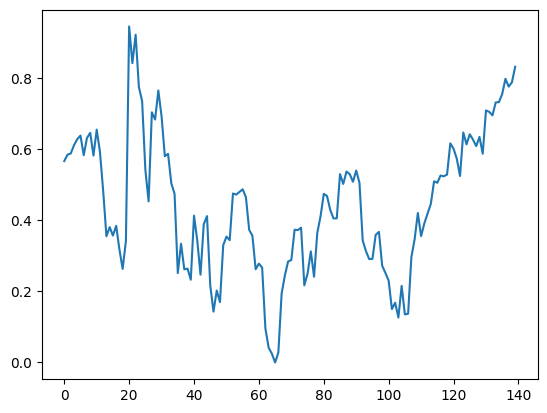

In [18]:
plt.plot(y_test[0].flatten())

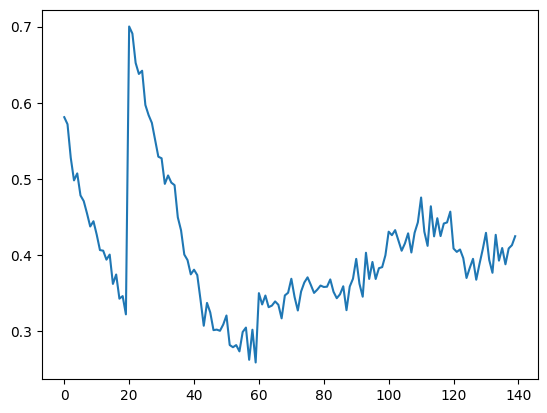

In [19]:
plt.plot(lstm_processed_signal[0].flatten())

In [20]:
# # initialize N-Beats and fit
# nbeats = NBeatsModel(model_type = 'generic', lookback = x_length, horizon = 1)
# nbeats.fit(x_train[0], y_train[0], epochs = 30)

In [21]:
post = postprocess.Postprocess()
processed_signal = post.postprocess_lstm(lstm_processed_signal, scaler)
pv_train_data = post.find_data_pv(train_data, pv_range)
pv_test_data = post.find_data_pv(test_data, pv_range)
pv_signal = post.find_data_pv(processed_signal, pv_range)
lead_train = post.find_lead(pv_train_data, pv_signal)
lead_test = post.find_lead(pv_test_data, pv_signal)
first_date, lead, pv = post.get_first_lead(pv_signal, lead_test)

In [22]:
train_data.shape

(10, 200)

In [23]:
# processed_signal, best_fit_harm, best_fit_error = post.postprocess_fft(
#     mixed_train_harm, mixed_test_harm, pv_range, pv_train_data, fit_method)
# pv_signal = post.find_data_pv(processed_signal, pv_range)

In [24]:
lead_train = post.find_lead(pv_train_data, pv_signal)
lead_test = post.find_lead(pv_test_data, pv_signal)
first_date, lead, pv = post.get_first_lead(pv_signal, lead_test)

In [25]:
best_fit_harm = None
best_fit_error = None

In [26]:
evaluater = evaluateModel.Evaluate()
result_table, average_lead = evaluater.evaluate_model(processed_signal, all_data_index, test_data_index, best_fit_harm, best_fit_error, first_date, lead, pv)
print('average_lead = ', average_lead)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(result_table)

average_lead =  8.9


,s_date,t_date,lead,ans_date,pv,best_fit,error
0,2010-01-04,2010-02-01,5,2010-02-08,valley,NaN,NaN
1,2010-02-02,2010-03-03,36,2010-04-23,peak,NaN,NaN
2,2010-03-03,2010-03-30,27,2010-05-07,valley,NaN,NaN
3,2010-03-31,2010-05-10,-1,2010-05-07,valley,NaN,NaN
4,2010-04-29,2010-06-09,-2,2010-06-07,valley,NaN,NaN
5,2010-05-27,2010-07-08,-3,2010-07-02,valley,NaN,NaN
6,2010-06-25,2010-07-07,-2,2010-07-02,valley,NaN,NaN
7,2010-07-26,2010-08-04,-4,2010-07-29,valley,NaN,NaN
8,2010-08-23,2010-09-01,-4,2010-08-26,valley,NaN,NaN
9,2010-09-21,2010-09-30,-5,2010-09-23,valley,NaN,NaN


evaluater = evaluateProfit.EvaluateProfit()

In [27]:
evaluater = evaluateProfit.EvaluateProfit()

total_profit = 126.159912109375


,in_date,in_price,out_date,out_price,pv,profit,profitability
0,2010-02-01,1073.89,2010-02-10,1068.13,valley,-5.76,-0.0054 %
1,2010-03-03,1119.36,2010-03-12,1149.99,peak,-30.63,-0.0274 %
2,2010-03-30,1173.75,2010-04-09,1194.37,valley,20.62,0.0176 %
3,2010-05-10,1122.27,2010-05-19,1115.05,valley,-7.22,-0.0064 %
4,2010-06-09,1062.75,2010-06-18,1117.51,valley,54.76,0.0515 %
5,2010-07-08,1062.92,2010-07-19,1071.25,valley,8.33,0.0078 %
6,2010-07-07,1028.54,2010-07-16,1064.88,valley,36.34,0.0353 %
7,2010-08-04,1121.06,2010-08-13,1079.25,valley,-41.81,-0.0373 %
8,2010-09-01,1049.72,2010-09-13,1121.9,valley,72.18,0.0688 %
9,2010-09-30,1145.97,2010-10-11,1165.32,valley,19.35,0.0169 %


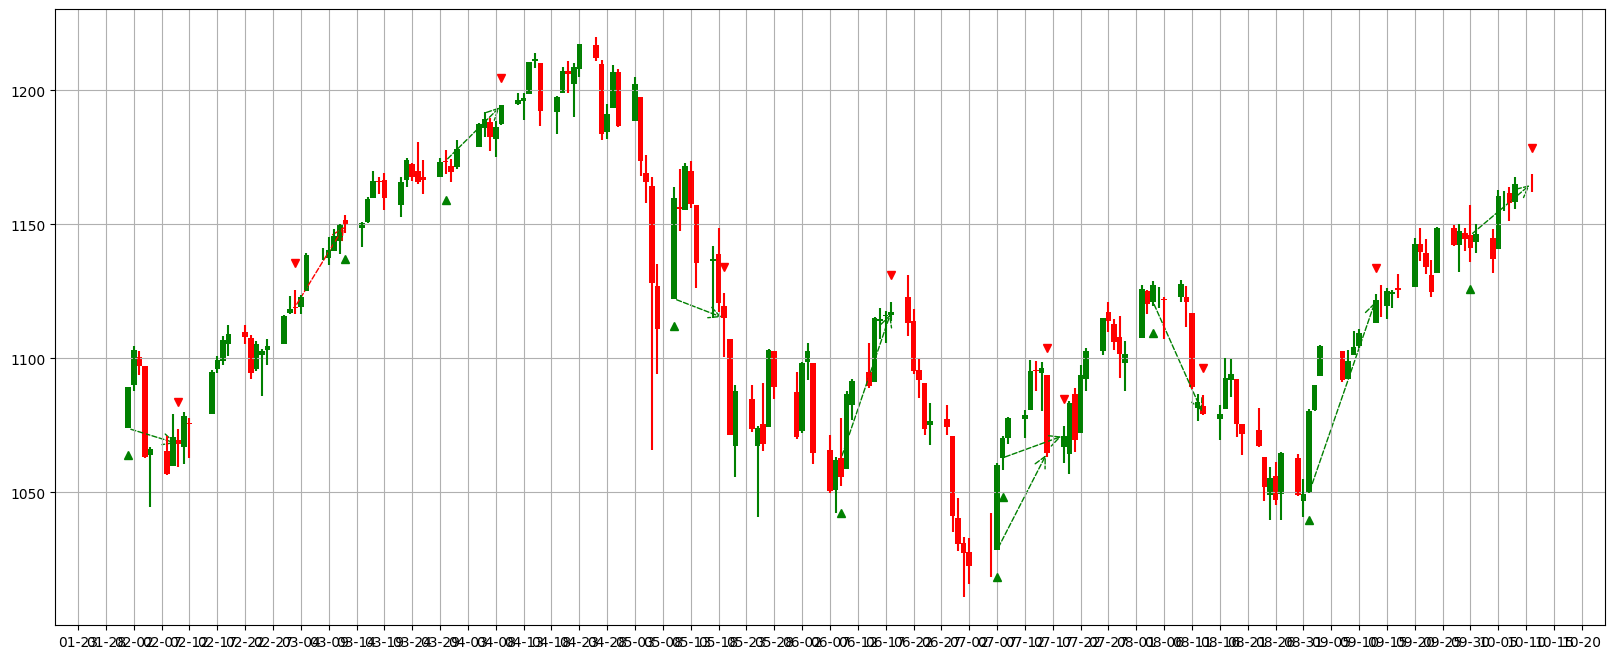

In [28]:
total_profit, profit_table = evaluater.build_profit_table_strategy_1(result_table, all_data, pv_range)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(profit_table)
evaluater.draw_profit_plot(profit_table, all_data)

total_profit = 126.159912109375


,in_date,in_price,out_date,out_price,pv,profit,strategy,strategy_price,profitability
0,2010-02-01,1073.89,2010-02-10,1068.13,valley,-5.76,NaN,NaN,-0.0054 %
1,2010-03-03,1119.36,2010-03-12,1149.99,peak,-30.63,NaN,NaN,-0.0274 %
2,2010-03-30,1173.75,2010-04-09,1194.37,valley,20.62,NaN,NaN,0.0176 %
3,2010-05-10,1122.27,2010-05-19,1115.05,valley,-7.22,NaN,NaN,-0.0064 %
4,2010-06-09,1062.75,2010-06-18,1117.51,valley,54.76,NaN,NaN,0.0515 %
5,2010-07-08,1062.92,2010-07-19,1071.25,valley,8.33,NaN,NaN,0.0078 %
6,2010-07-07,1028.54,2010-07-16,1064.88,valley,36.34,NaN,NaN,0.0353 %
7,2010-08-04,1121.06,2010-08-13,1079.25,valley,-41.81,NaN,NaN,-0.0373 %
8,2010-09-01,1049.72,2010-09-13,1121.9,valley,72.18,NaN,NaN,0.0688 %
9,2010-09-30,1145.97,2010-10-11,1165.32,valley,19.35,NaN,NaN,0.0169 %


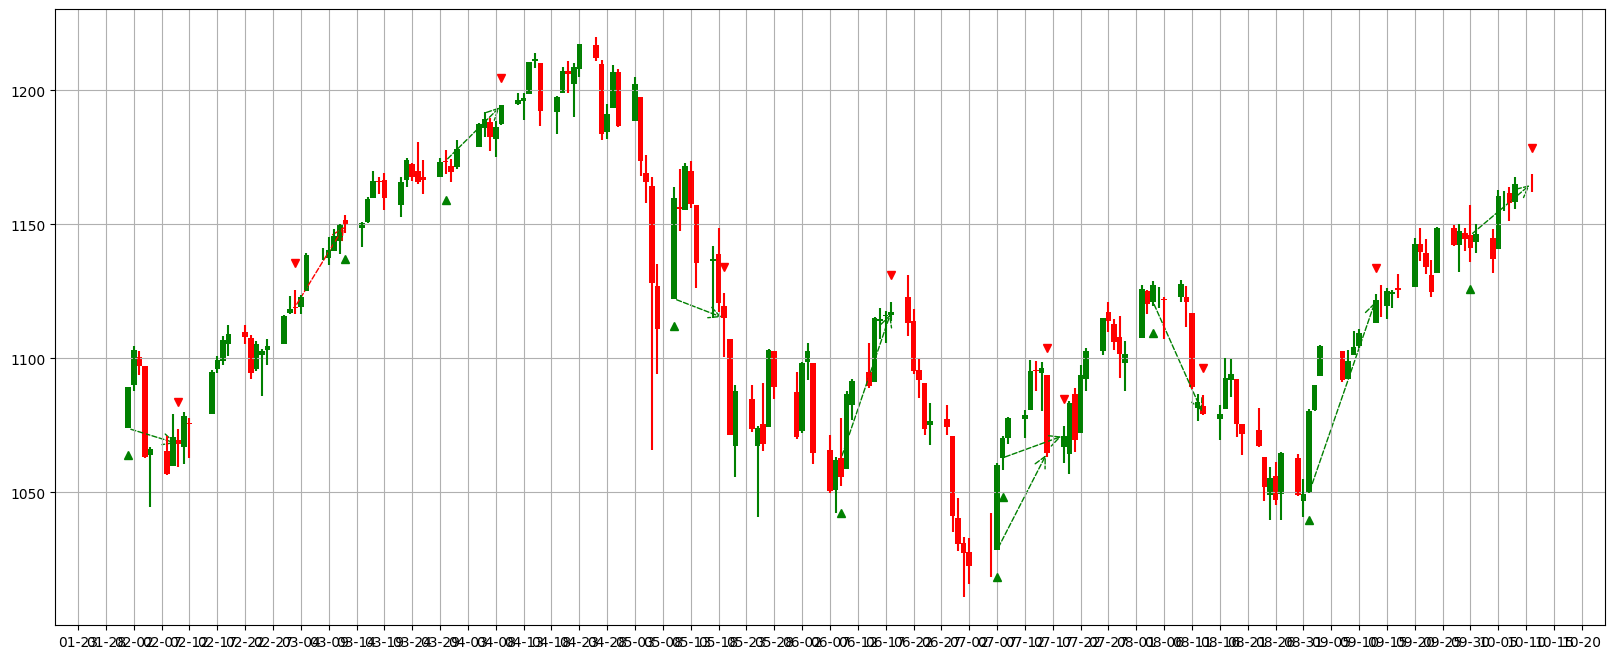

In [29]:
total_profit, profit_table = evaluater.build_profit_table_strategy_2(result_table, all_data, profit_percentage, loss_percentage, pv_range)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(profit_table)
evaluater.draw_profit_plot(profit_table, all_data)

total_profit = 126.159912109375


,in_date,in_price,out_date,out_price,pv,profit,strategy,strategy_price,profitability
0,2010-02-01,1073.89,2010-02-10,1068.13,valley,-5.76,NaN,NaN,-0.0054 %
1,2010-03-03,1119.36,2010-03-12,1149.99,peak,-30.63,NaN,NaN,-0.0274 %
2,2010-03-30,1173.75,2010-04-09,1194.37,valley,20.62,NaN,NaN,0.0176 %
3,2010-05-10,1122.27,2010-05-19,1115.05,valley,-7.22,NaN,NaN,-0.0064 %
4,2010-06-09,1062.75,2010-06-18,1117.51,valley,54.76,NaN,NaN,0.0515 %
5,2010-07-08,1062.92,2010-07-19,1071.25,valley,8.33,NaN,NaN,0.0078 %
6,2010-07-07,1028.54,2010-07-16,1064.88,valley,36.34,NaN,NaN,0.0353 %
7,2010-08-04,1121.06,2010-08-13,1079.25,valley,-41.81,NaN,NaN,-0.0373 %
8,2010-09-01,1049.72,2010-09-13,1121.9,valley,72.18,NaN,NaN,0.0688 %
9,2010-09-30,1145.97,2010-10-11,1165.32,valley,19.35,NaN,NaN,0.0169 %


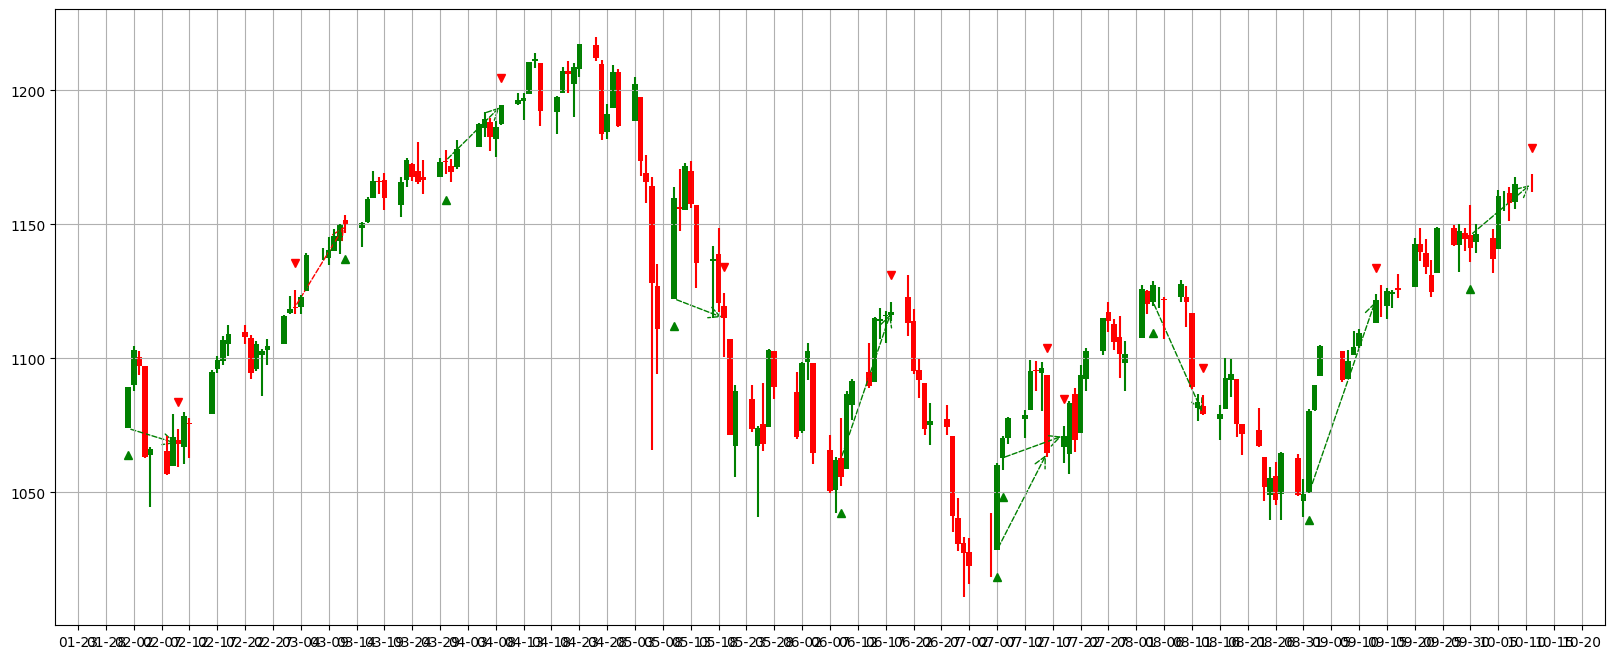

In [30]:
total_profit, profit_table = evaluater.build_profit_table_strategy_3(result_table, all_data, profit_percentage, loss_percentage, pv_range)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(profit_table)
evaluater.draw_profit_plot(profit_table, all_data)

In [37]:
# fig, ax = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
# ax[0].plot(y_test[0].flatten(), label='y_test')
# ax[1].plot(lstm_processed_signal[0].flatten(), label='signal')
# # for x , pv in enumerate(pv_test_data[0]):
# #     if pv == 1:
# #         ax[0].plot(x, y_test[0].flatten()[x], '^', color='orange')
# #     elif pv == -1:
# #         ax[0].plot(x, y_test[0].flatten()[x], 'v', color='red')
# # for x , pv in enumerate(pv_signal[0]):
# #     if pv == 1:
# #         ax[1].plot(x, lstm_processed_signal[0].flatten()[x], '^', color='orange')
# #     elif pv == -1:
# #         ax[1].plot(x, lstm_processed_signal[0].flatten()[x], 'v', color='red')
# ax[0].legend()
# ax[1].legend()
# plt.show()

In [38]:
y_test.shape

(10, 7, 20, 1)

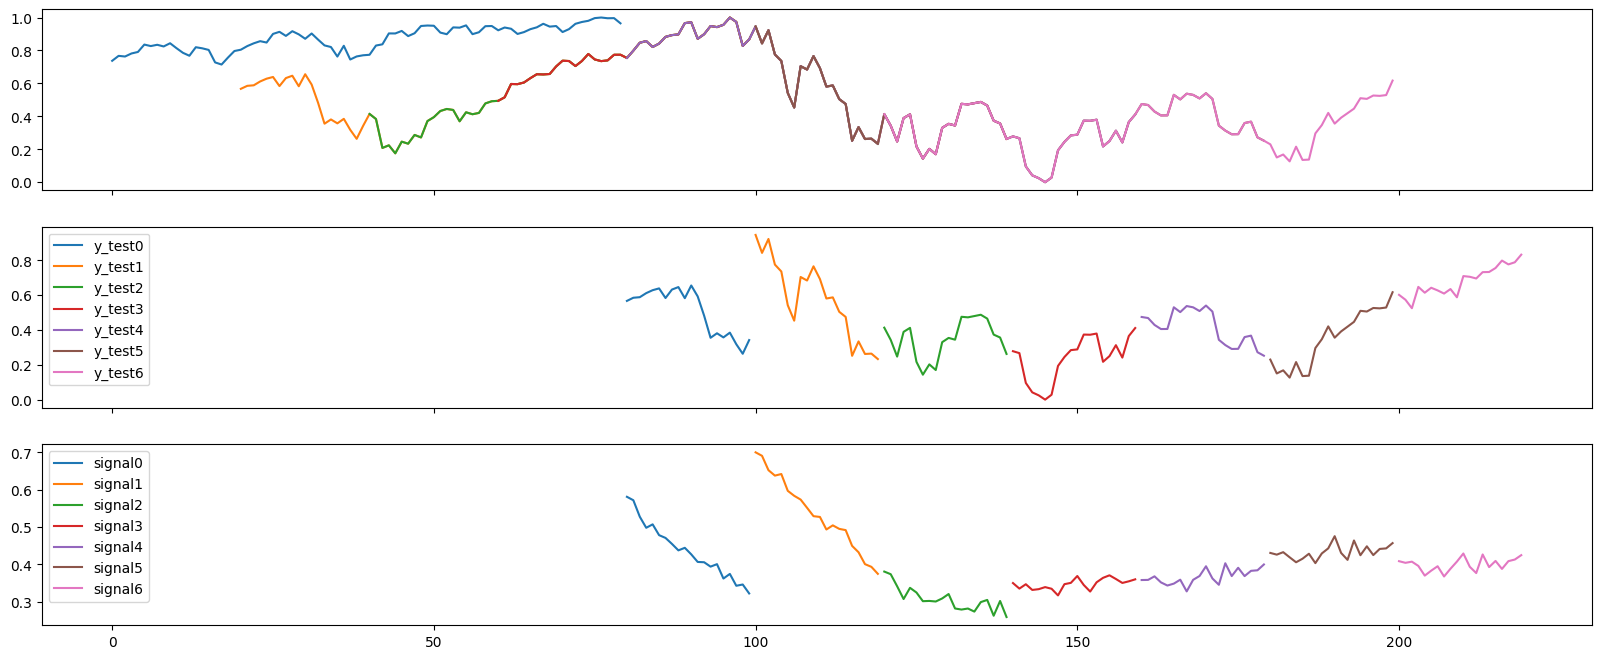

In [39]:
fig, ax = plt.subplots(3, 1, figsize=(20, 8), sharex=True)
count=0
for i in range(0, x_test.shape[1]): 
    # print(i)
    countx=range(count, count+x_length)
    county=range(count+x_length, count+x_length+y_length)
    ax[0].plot(countx, x_test[0, i, :], label=f'x_test{i}')
    ax[1].plot(county, y_test[0, i], label=f'y_test{i}')
    ax[2].plot(county, lstm_processed_signal[0, i], label=f'signal{i}')
    count+=slide
# for x , pv in enumerate(pv_test_data[0]):
#     if pv == 1:
#         ax[1].plot(x, y_test[0].flatten()[x], '^', color='orange')
#     elif pv == -1:
#         ax[1].plot(x, y_test[0].flatten()[x], 'v', color='red')
# for x , pv in enumerate(pv_signal[1]):
#     if pv == 1:
#         ax[2].plot(x, lstm_processed_signal[0].flatten()[x], '^', color='orange')
#     elif pv == -1:
#         ax[2].plot(x, lstm_processed_signal[0].flatten()[x], 'v', color='red')
# ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

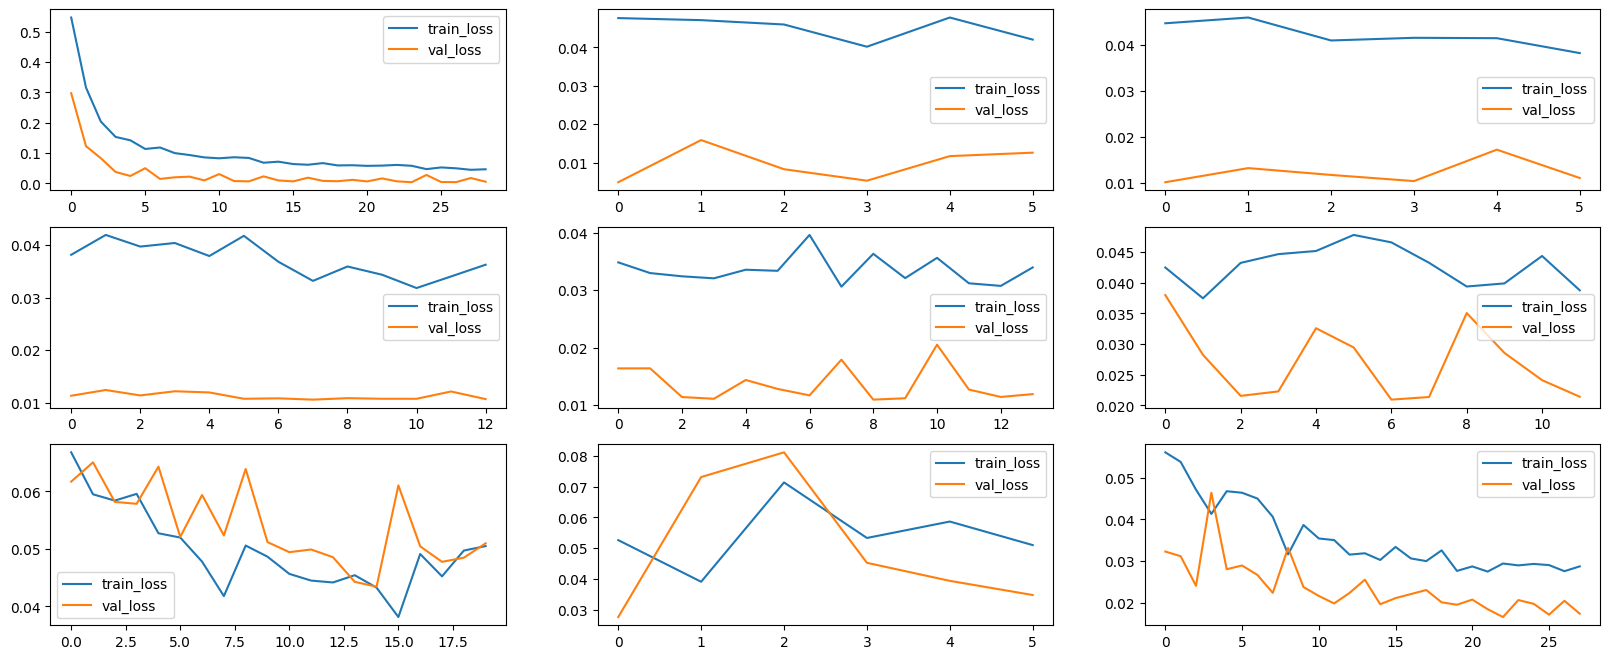

In [41]:
fig, ax = plt.subplots(3, 3, figsize=(20, 8))
i=0
for window in range(9):
    # visualizing losses and accuracy
    train_loss = history[window].history['loss']
    val_loss   = history[window].history['val_loss']
    # plt.title(f'window{window}')
    ax[i//3, i%3].plot(train_loss, label='train_loss')
    ax[i//3, i%3].plot(val_loss, label='val_loss')
    ax[i//3, i%3].legend()
    i+=1
plt.show()


In [42]:
def compute_rmse(predict_value, actual_value):
    absolute_error = np.abs(predict_value - actual_value)
    rmse = np.sqrt(np.mean(absolute_error**2))
    return rmse

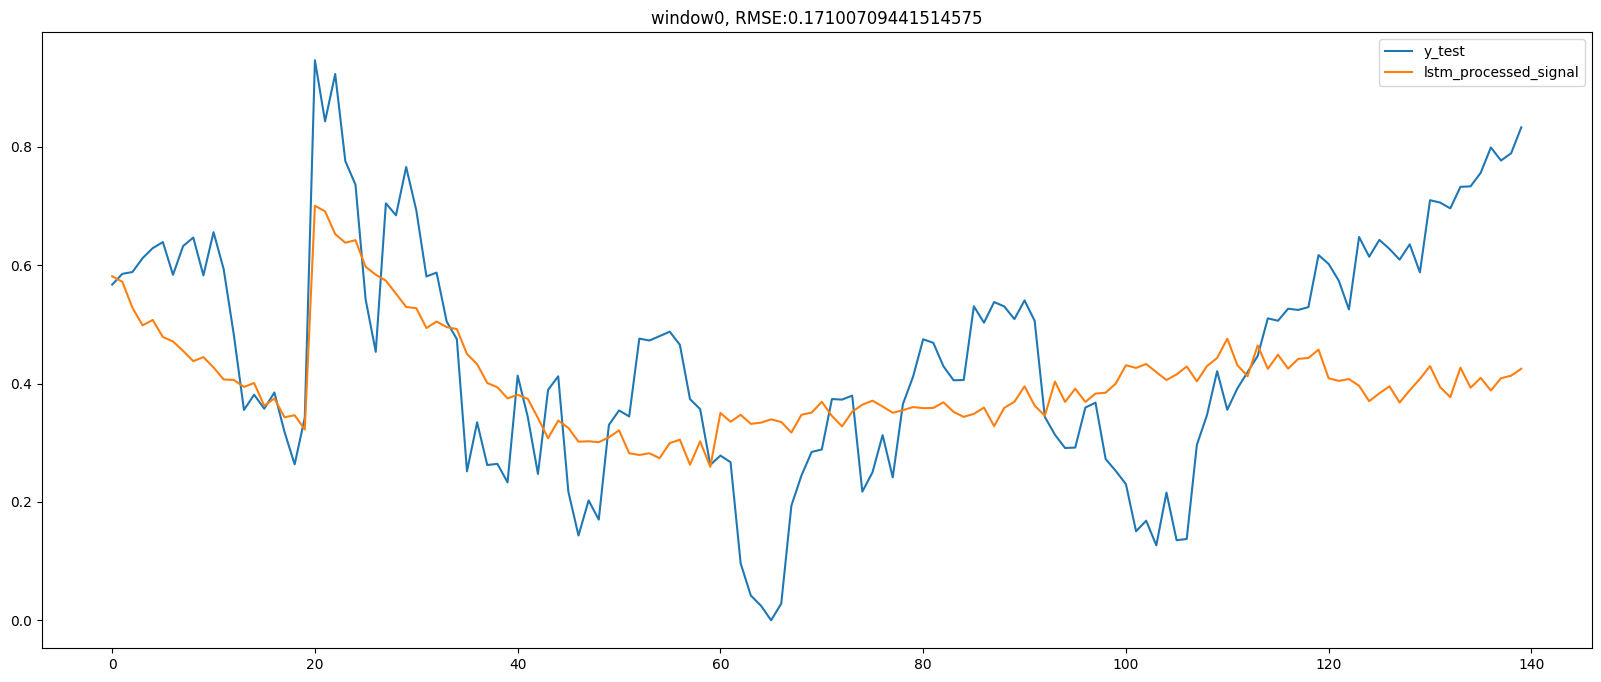

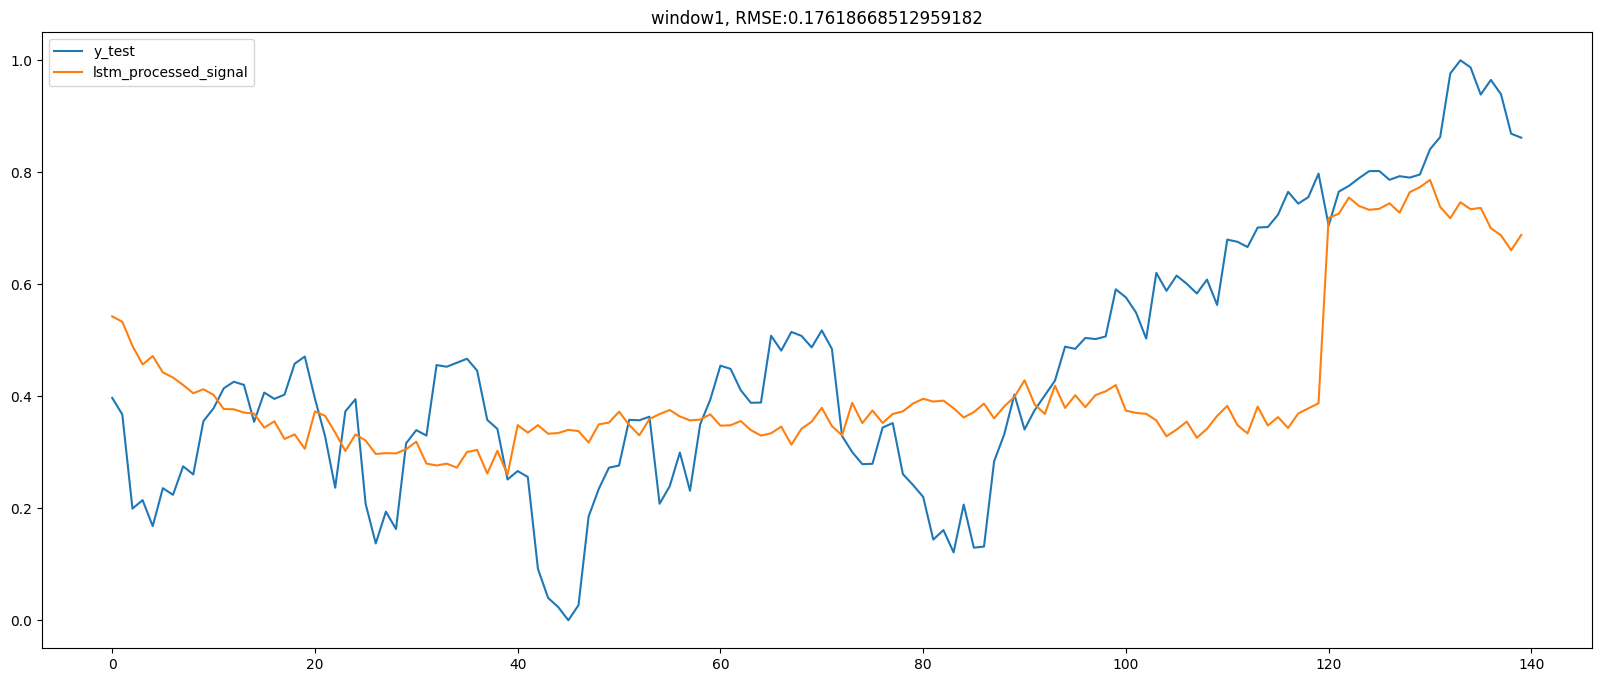

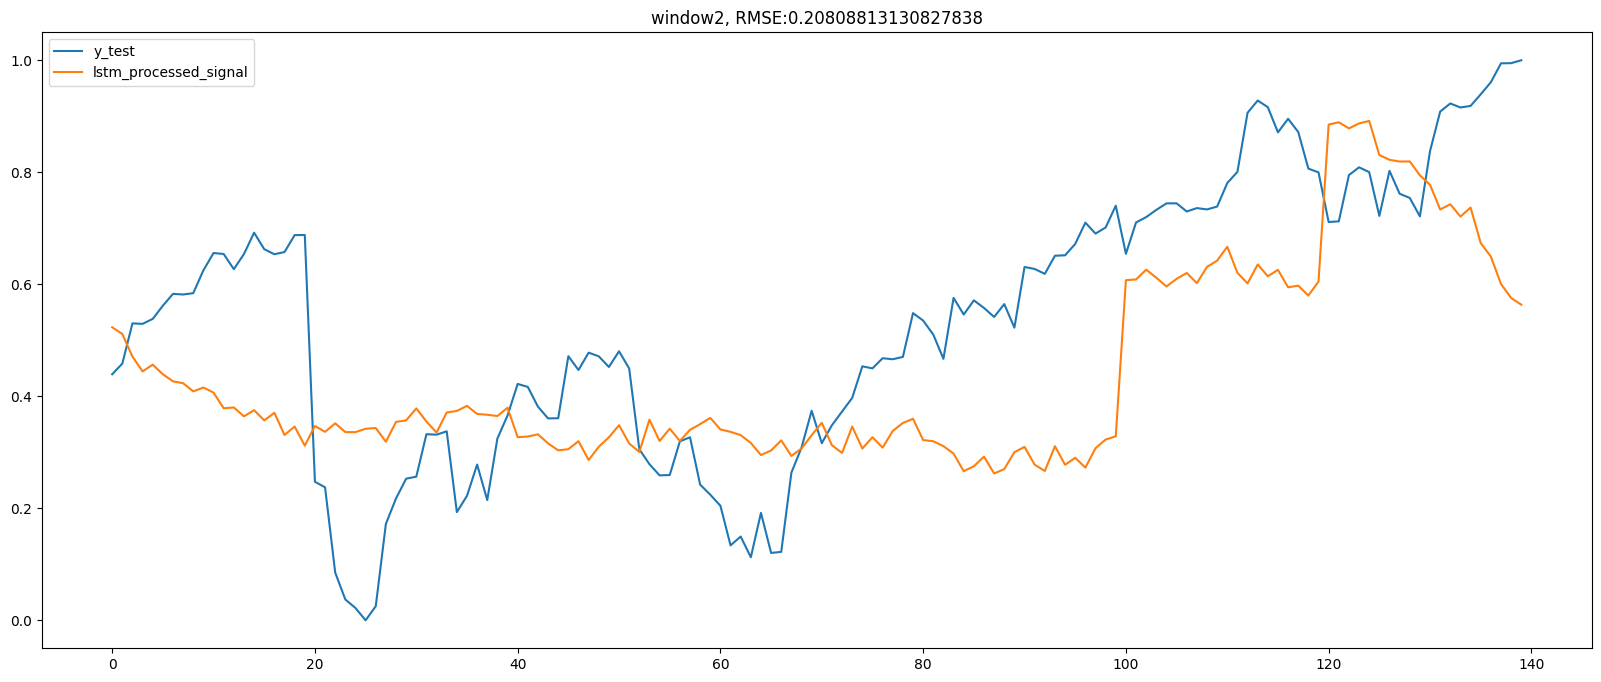

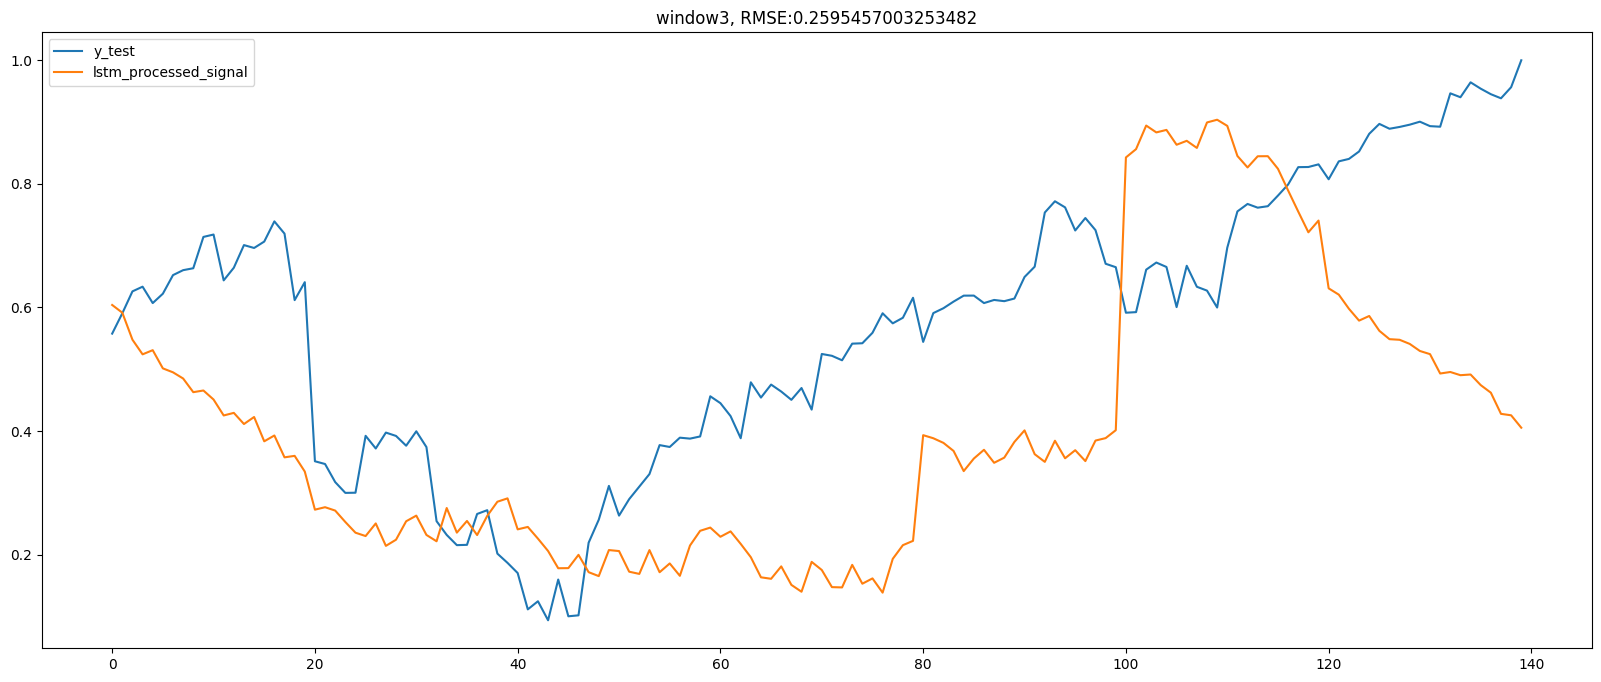

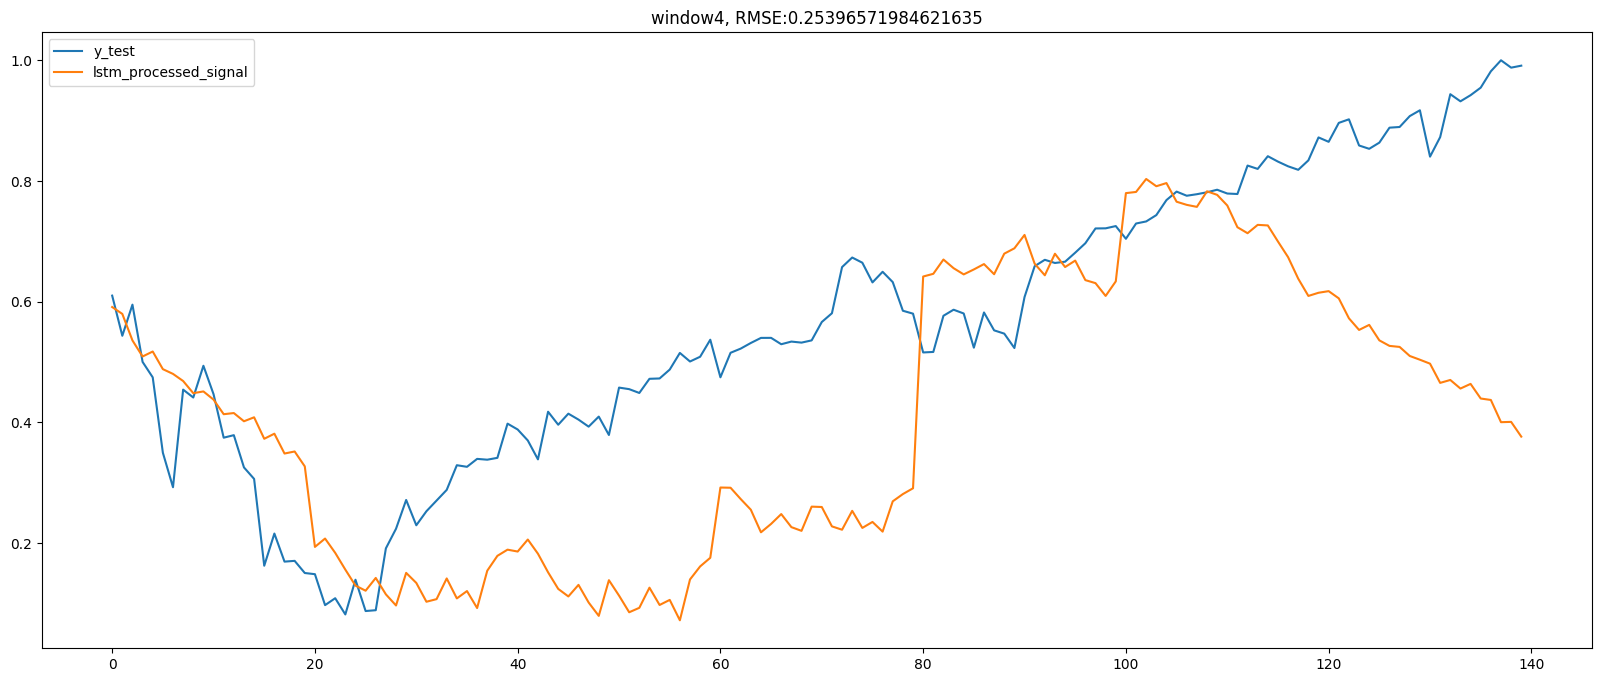

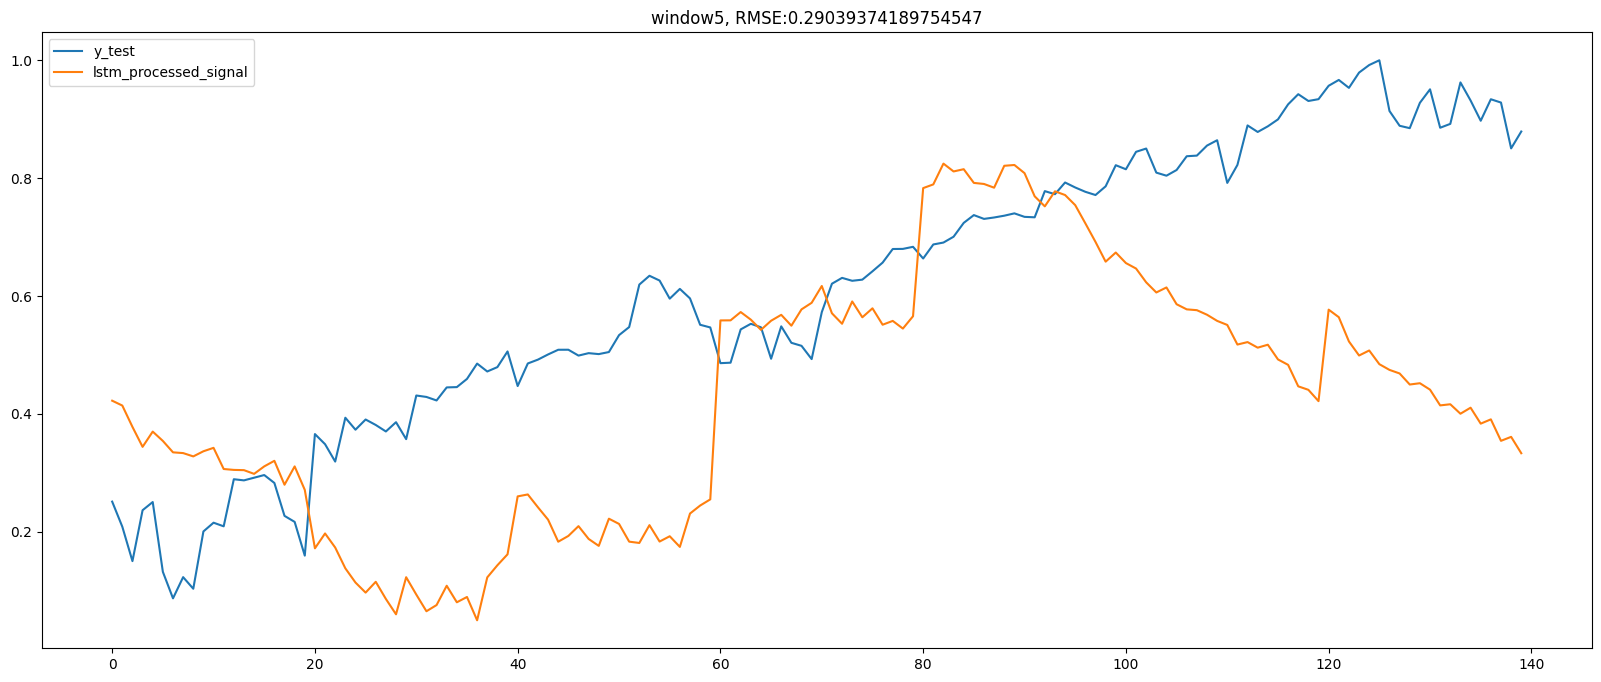

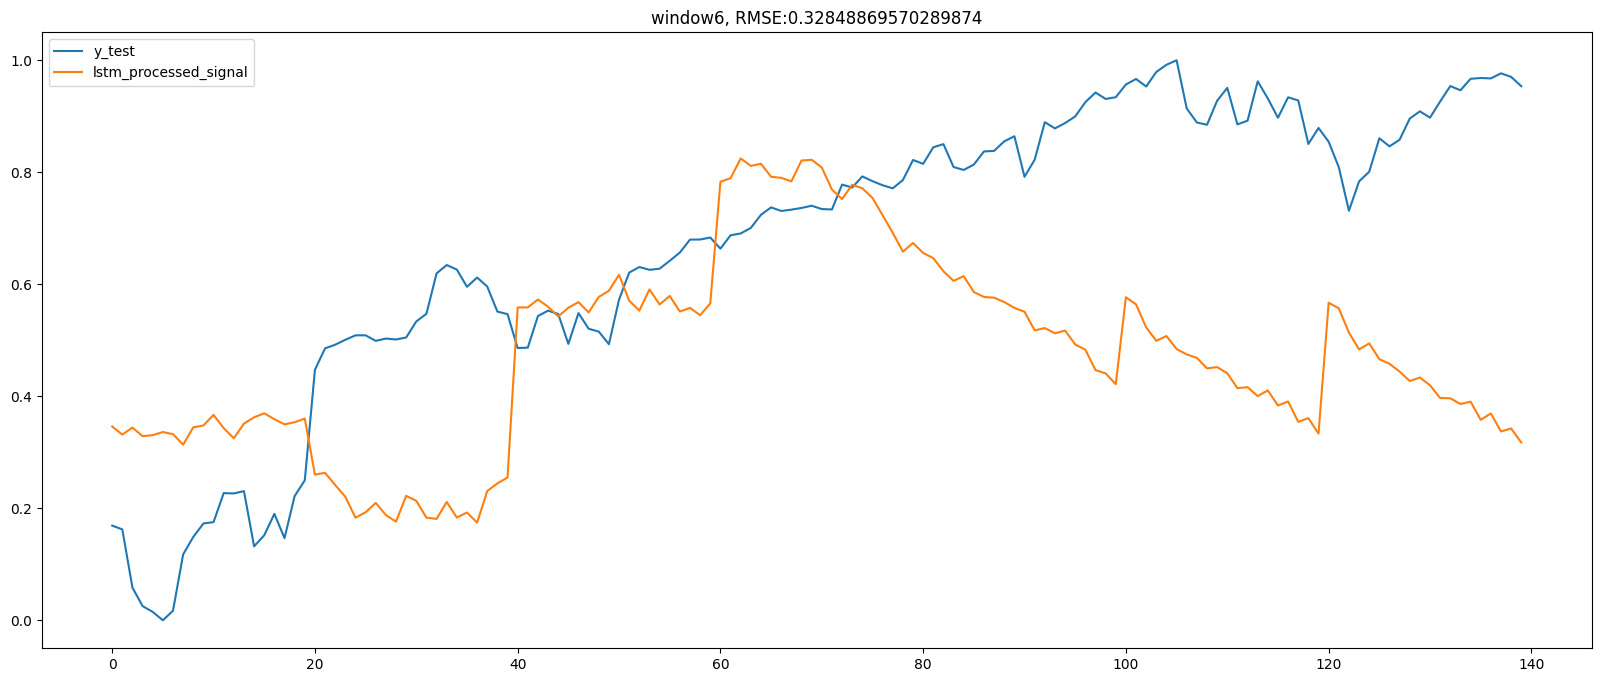

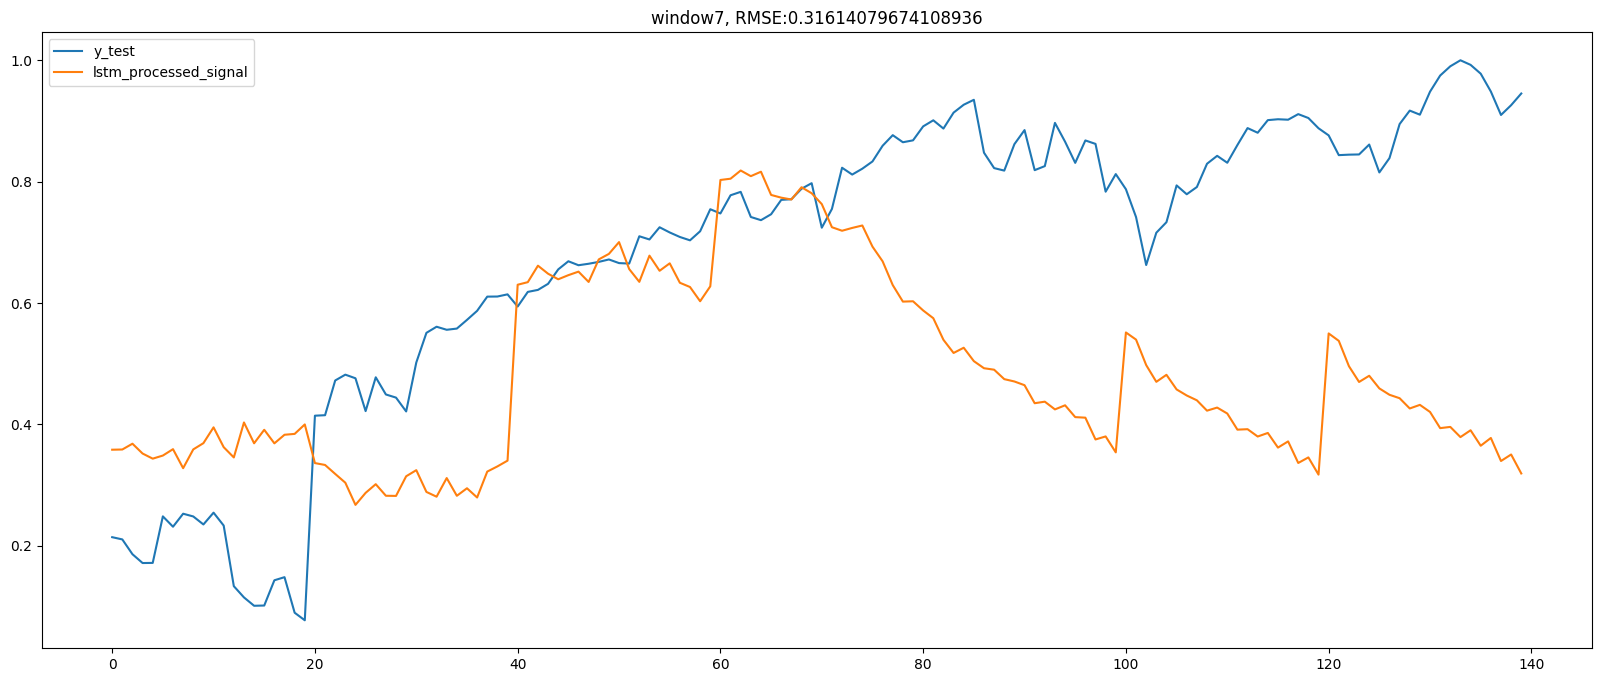

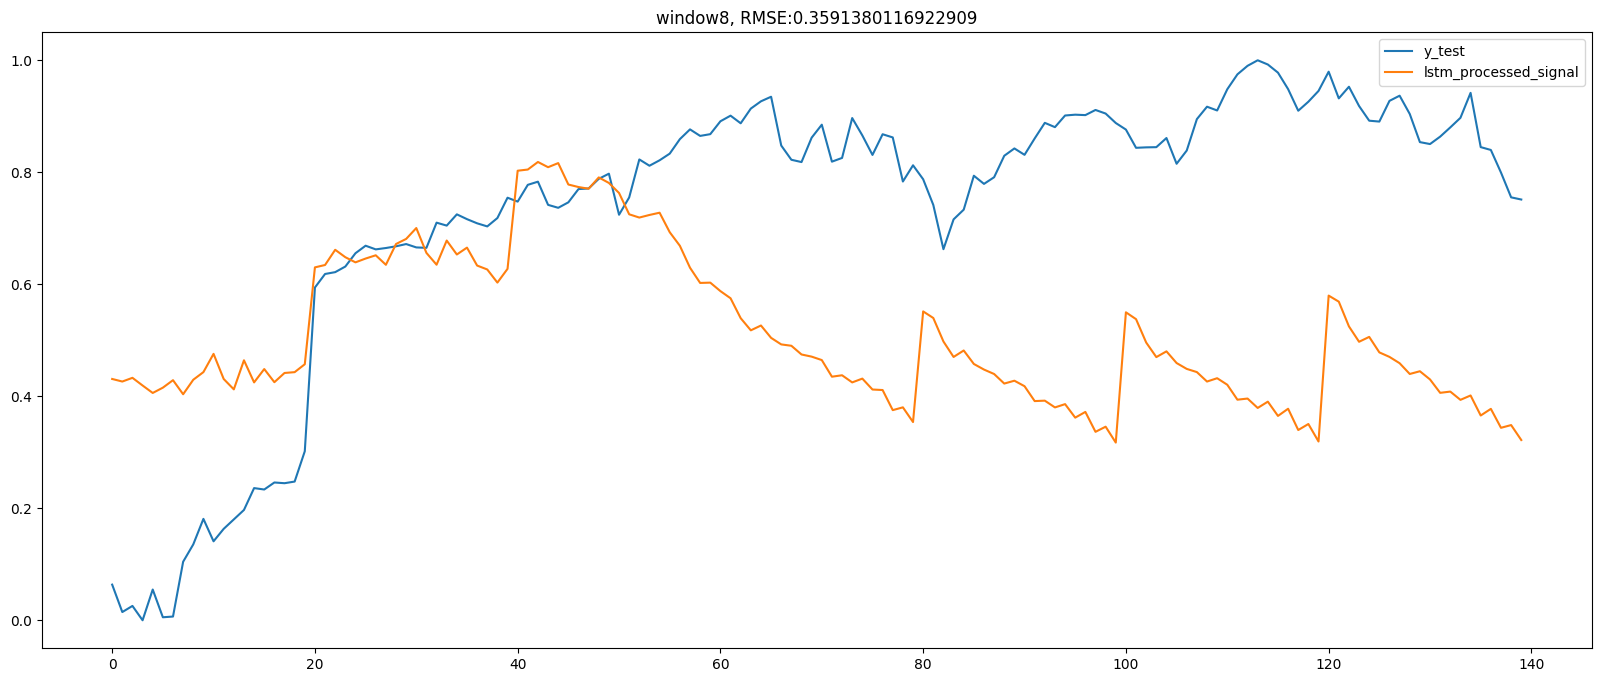

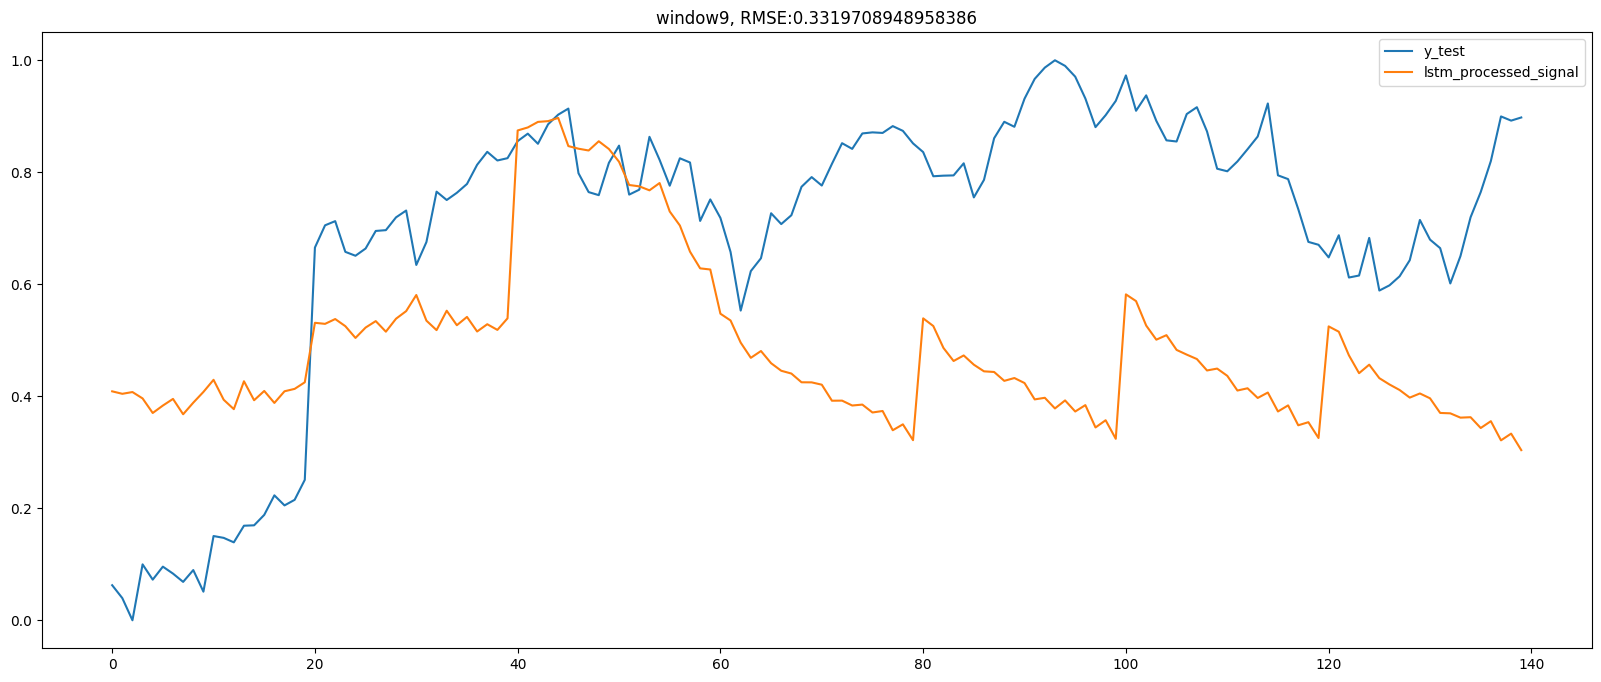

average_rmse=0.2694925471954243


In [43]:
rmse_list = list()
for window in range(test_data.shape[0]):
    RMSE = compute_rmse(lstm_processed_signal[window].flatten(), y_test[window].flatten())
    rmse_list.append(RMSE)
    plt.figure(figsize=(20, 8))
    plt.title(f'window{window}, RMSE:{RMSE}')
    plt.plot(y_test[window].flatten(), label='y_test')
    plt.plot(lstm_processed_signal[window].flatten(), label='lstm_processed_signal')
    plt.legend()
    plt.show()
average_rmse = sum(rmse_list) / len(rmse_list)
print(f'average_rmse={average_rmse}')